# Layout Detection with DocLayout-YOLO
Detect document layout regions (text blocks, titles, tables, figures) using DocLayout-YOLO.

**Features:**
- **Deskewing:** Automatically straightens skewed/rotated scans before detection
- **DocLayout-YOLO:** Fast and accurate document layout detection

In [1]:
# Install dependencies (run once)
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install required packages
print("Installing dependencies...")

# Install doclayout-yolo (includes the custom model code)
install("doclayout-yolo")

# Other dependencies
packages = ["torch", "torchvision", "pillow", "matplotlib", "huggingface_hub", "opencv-python", "scipy"]
for pkg in packages:
    try:
        __import__(pkg.replace("-", "_").split("[")[0])
    except ImportError:
        print(f"Installing {pkg}...")
        install(pkg)

print("Dependencies ready!")

Installing dependencies...
Installing pillow...
Installing opencv-python...
Dependencies ready!


In [2]:
import os
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
import torch
import cv2
from scipy import ndimage

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cpu
CUDA available: False


In [3]:
# Configuration
INPUT_FOLDER = Path("filled_documents")
OUTPUT_FOLDER = Path("layout_results")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# Library name for output files
LIBRARY_NAME = "doclayout_yolo"

# Confidence threshold (0-1)
CONFIDENCE_THRESHOLD = 0.5

# Deskew settings
ENABLE_DESKEW = True
DESKEW_ANGLE_THRESHOLD = 0.5  # Only deskew if angle > this value (degrees)

## Deskewing Functions
These functions detect and correct skew in document images before layout detection.

In [4]:
def detect_skew_angle(image: np.ndarray) -> float:
    """
    Detect the skew angle of a document image using Hough Line Transform.
    
    Args:
        image: Input image as numpy array (RGB or grayscale)
    
    Returns:
        Skew angle in degrees (positive = clockwise rotation needed)
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Dilate edges to connect broken lines
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=100,
        minLineLength=100,
        maxLineGap=10
    )
    
    if lines is None or len(lines) == 0:
        return 0.0
    
    # Calculate angles of detected lines
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            continue
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        
        # Only consider nearly horizontal lines (within 45 degrees of horizontal)
        if abs(angle) < 45:
            angles.append(angle)
    
    if len(angles) == 0:
        return 0.0
    
    # Use median angle to be robust to outliers
    median_angle = np.median(angles)
    
    return median_angle


def deskew_image(image: np.ndarray, angle: float = None, background_color: tuple = (255, 255, 255)) -> tuple:
    """
    Deskew (straighten) a document image.
    
    Args:
        image: Input image as numpy array (RGB)
        angle: Skew angle in degrees. If None, it will be auto-detected.
        background_color: Color to fill empty areas after rotation
    
    Returns:
        Tuple of (deskewed_image, detected_angle)
    """
    if angle is None:
        angle = detect_skew_angle(image)
    
    if abs(angle) < DESKEW_ANGLE_THRESHOLD:
        # Angle is negligible, no deskewing needed
        return image, angle
    
    # Get image dimensions
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Calculate rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new image bounds to avoid cropping
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Adjust rotation matrix for new bounds
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]
    
    # Perform rotation
    deskewed = cv2.warpAffine(
        image,
        rotation_matrix,
        (new_w, new_h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=background_color
    )
    
    return deskewed, angle


def preprocess_for_layout(pil_image: Image.Image, enable_deskew: bool = True) -> tuple:
    """
    Preprocess a PIL image for layout detection.
    
    Args:
        pil_image: Input PIL Image
        enable_deskew: Whether to apply deskewing
    
    Returns:
        Tuple of (preprocessed_pil_image, skew_angle)
    """
    image_array = np.array(pil_image)
    
    if enable_deskew:
        deskewed_array, angle = deskew_image(image_array)
        return Image.fromarray(deskewed_array), angle
    else:
        return pil_image, 0.0


print("Deskewing functions loaded!")

Deskewing functions loaded!


In [5]:
# Load DocLayout-YOLO model for document layout detection
from doclayout_yolo import YOLOv10
from huggingface_hub import hf_hub_download

print("Downloading document layout detection model...")

# Download model from Hugging Face
model_path = hf_hub_download(
    repo_id="juliozhao/DocLayout-YOLO-DocStructBench",
    filename="doclayout_yolo_docstructbench_imgsz1024.pt"
)

# Load model
model = YOLOv10(model_path)
print("Model loaded!")

# Print available classes
print("\nDetectable classes:")
for idx, name in model.names.items():
    print(f"  {idx}: {name}")

Model loaded!

Detectable classes:
  0: title
  1: plain text
  2: abandon
  3: figure
  4: figure_caption
  5: table
  6: table_caption
  7: table_footnote
  8: isolate_formula
  9: formula_caption


In [6]:
# List available documents
image_extensions = {'.png', '.jpg', '.jpeg', '.tiff', '.bmp'}
documents = sorted([f for f in INPUT_FOLDER.iterdir() 
                    if f.suffix.lower() in image_extensions])

if not documents:
    print(f"No images found in '{INPUT_FOLDER}' folder.")
    print("Run the form_filler and scan_simulator notebooks first.")
else:
    print(f"Found {len(documents)} documents:")
    for i, doc in enumerate(documents):
        print(f"  {i}: {doc.name}")

Found 24 documents:
  0: Demand Letter_batch_1.png
  1: Demand Letter_batch_1_1.png
  2: Demand Letter_batch_1_2.png
  3: Demand Letter_batch_1_3.png
  4: Demand Letter_batch_1_4.png
  5: Demand Letter_batch_1_5.png
  6: Demand Letter_batch_2.png
  7: Demand Letter_batch_2_1.png
  8: Demand Letter_batch_2_2.png
  9: Demand Letter_batch_2_3.png
  10: Demand Letter_batch_2_4.png
  11: Demand Letter_batch_2_5.png
  12: Demand Letter_filled_computer.png
  13: Demand Letter_filled_computer_1.png
  14: Demand Letter_filled_computer_2.png
  15: Demand Letter_filled_computer_3.png
  16: Demand Letter_filled_computer_4.png
  17: Demand Letter_filled_computer_5.png
  18: Demand Letter_filled_handwriting.png
  19: Demand Letter_filled_handwriting_1.png
  20: Demand Letter_filled_handwriting_2.png
  21: Demand Letter_filled_handwriting_3.png
  22: Demand Letter_filled_handwriting_4.png
  23: Demand Letter_filled_handwriting_5.png


Selected: Demand Letter_batch_1.png
Original image size: (1224, 1584)

Deskewing enabled: True
Detected skew angle: 0.00 degrees
Processed image size: (1224, 1584)


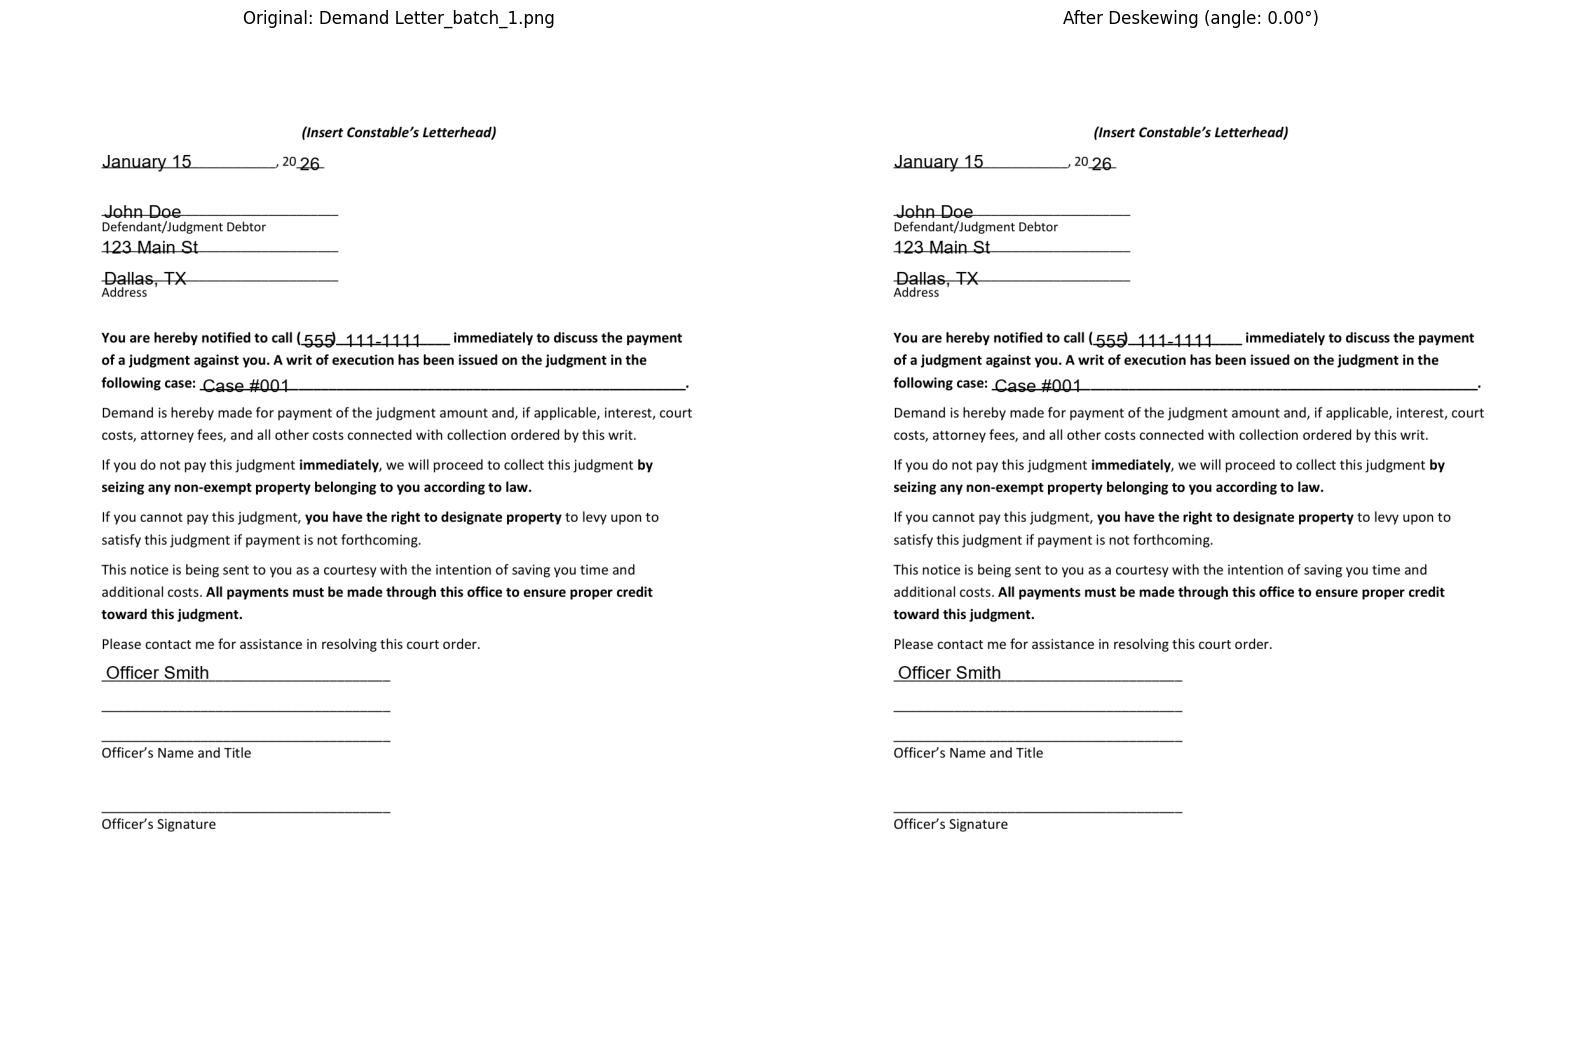

In [7]:
# ============================================================
# CONFIGURATION: Select document to analyze
# ============================================================
SELECTED_DOC_INDEX = 0  # Change this to select a different document

if documents:
    selected_doc = documents[SELECTED_DOC_INDEX]
    print(f"Selected: {selected_doc.name}")
    
    # Load image
    original_image = Image.open(selected_doc).convert("RGB")
    print(f"Original image size: {original_image.size}")
    
    # Apply deskewing
    print(f"\nDeskewing enabled: {ENABLE_DESKEW}")
    image, skew_angle = preprocess_for_layout(original_image, enable_deskew=ENABLE_DESKEW)
    print(f"Detected skew angle: {skew_angle:.2f} degrees")
    print(f"Processed image size: {image.size}")
    
    # Display comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    
    axes[0].imshow(np.array(original_image))
    axes[0].set_title(f"Original: {selected_doc.name}")
    axes[0].axis('off')
    
    axes[1].imshow(np.array(image))
    axes[1].set_title(f"After Deskewing (angle: {skew_angle:.2f}°)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No documents available")

In [8]:
# Run layout detection on deskewed image
if 'image' in dir():
    print("Running layout detection...")
    
    # Run inference
    results = model(image, conf=CONFIDENCE_THRESHOLD, verbose=False)
    
    # Get detections
    detections = results[0].boxes
    
    print(f"\nDetected {len(detections)} regions:")
    print("-" * 60)
    
    layout_results = []
    for i, box in enumerate(detections):
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]
        conf = float(box.conf[0])
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        
        layout_results.append({
            "id": i + 1,
            "type": cls_name,
            "confidence": conf,
            "bbox": {"x1": int(x1), "y1": int(y1), "x2": int(x2), "y2": int(y2)}
        })
        
        print(f"{i+1}. Type: {cls_name:15} | Score: {conf:.2f} | "
              f"Box: ({int(x1)}, {int(y1)}) - ({int(x2)}, {int(y2)})")
else:
    print("Load a document first (run the cell above)")

Running layout detection...

Detected 10 regions:
------------------------------------------------------------
1. Type: plain text      | Score: 0.94 | Box: (141, 666) - (1016, 733)
2. Type: plain text      | Score: 0.93 | Box: (140, 585) - (1073, 651)
3. Type: plain text      | Score: 0.92 | Box: (142, 749) - (1023, 815)
4. Type: plain text      | Score: 0.92 | Box: (141, 832) - (1017, 932)
5. Type: title           | Score: 0.86 | Box: (455, 146) - (768, 173)
6. Type: plain text      | Score: 0.79 | Box: (141, 269) - (521, 354)
7. Type: plain text      | Score: 0.64 | Box: (142, 189) - (499, 223)
8. Type: plain text      | Score: 0.63 | Box: (141, 374) - (519, 423)
9. Type: title           | Score: 0.61 | Box: (140, 467) - (1066, 571)
10. Type: plain text      | Score: 0.58 | Box: (140, 467) - (1066, 571)


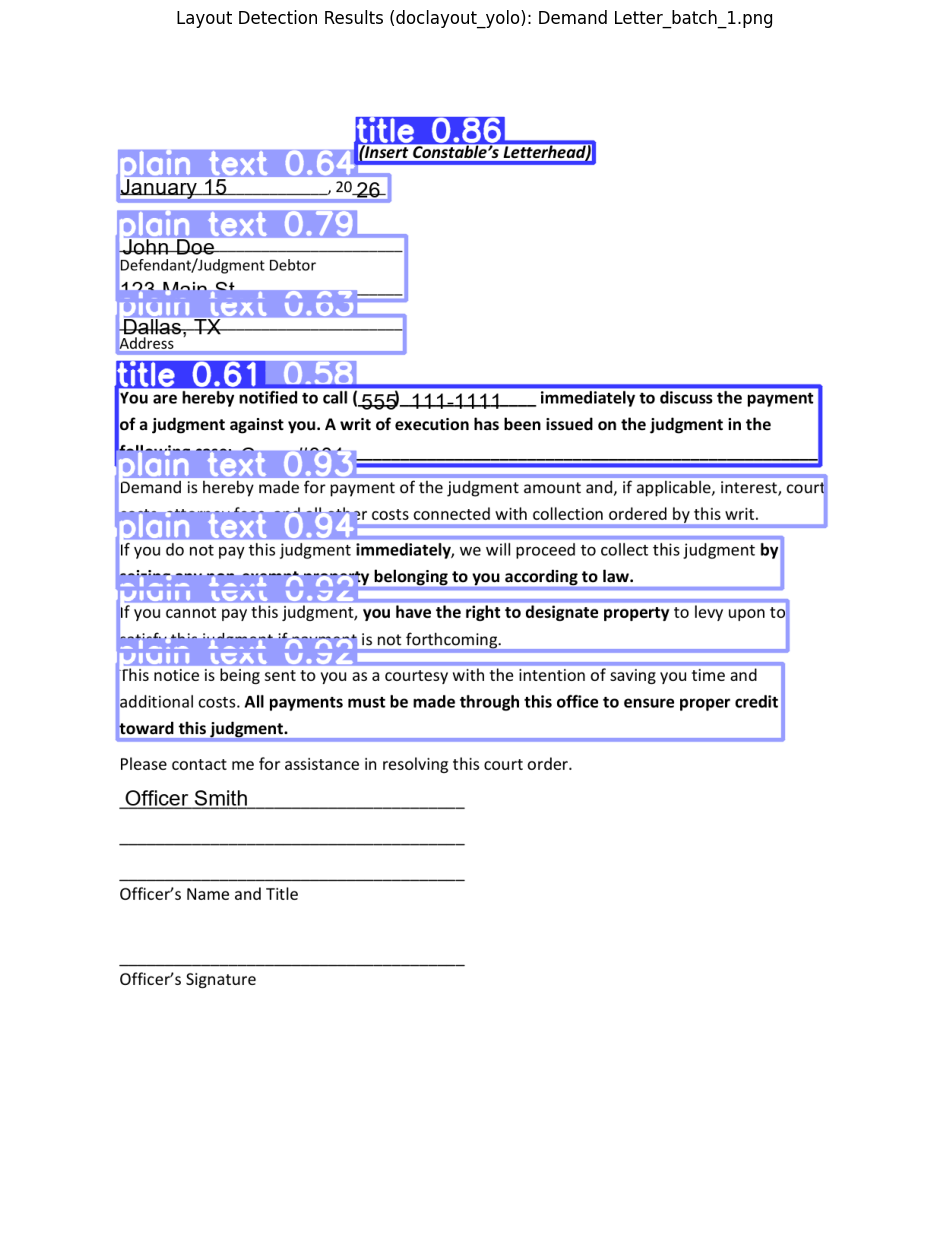

Saved visualization: layout_results\Demand Letter_batch_1_layout_doclayout_yolo.png


In [9]:
# Visualize detection results
if 'results' in dir():
    # YOLO has built-in visualization
    viz_image = results[0].plot()  # Returns numpy array with boxes drawn
    
    # Display
    plt.figure(figsize=(12, 16))
    plt.imshow(viz_image)
    plt.title(f"Layout Detection Results ({LIBRARY_NAME}): {selected_doc.name}")
    plt.axis('off')
    plt.show()
    
    # Save visualization with library postfix
    viz_path = OUTPUT_FOLDER / f"{selected_doc.stem}_layout_{LIBRARY_NAME}.png"
    Image.fromarray(viz_image).save(viz_path)
    print(f"Saved visualization: {viz_path}")
else:
    print("Run detection first (run the cell above)")

In [10]:
# Filter and extract specific region types
if 'layout_results' in dir():
    # Group by type
    regions_by_type = {}
    for region in layout_results:
        rtype = region["type"]
        if rtype not in regions_by_type:
            regions_by_type[rtype] = []
        regions_by_type[rtype].append(region)
    
    print("Regions by type:")
    print("-" * 40)
    for region_type, regions in regions_by_type.items():
        print(f"  {region_type}: {len(regions)} region(s)")

Regions by type:
----------------------------------------
  plain text: 8 region(s)
  title: 2 region(s)


In [11]:
# Crop and save individual regions
if 'layout_results' in dir() and len(layout_results) > 0:
    regions_folder = OUTPUT_FOLDER / f"{selected_doc.stem}_regions_{LIBRARY_NAME}"
    regions_folder.mkdir(exist_ok=True)
    
    print(f"Extracting regions to: {regions_folder}")
    
    for region in layout_results:
        bbox = region["bbox"]
        x1, y1, x2, y2 = bbox["x1"], bbox["y1"], bbox["x2"], bbox["y2"]
        
        # Crop region from deskewed image
        cropped = image.crop((x1, y1, x2, y2))
        
        # Save
        region_path = regions_folder / f"region_{region['id']}_{region['type']}.png"
        cropped.save(region_path)
        print(f"  Saved: {region_path.name}")
    
    print(f"\nExtracted {len(layout_results)} regions")

Extracting regions to: layout_results\Demand Letter_batch_1_regions_doclayout_yolo
  Saved: region_1_plain text.png
  Saved: region_2_plain text.png
  Saved: region_3_plain text.png
  Saved: region_4_plain text.png
  Saved: region_5_title.png
  Saved: region_6_plain text.png
  Saved: region_7_plain text.png
  Saved: region_8_plain text.png
  Saved: region_9_title.png
  Saved: region_10_plain text.png

Extracted 10 regions


In [12]:
# Export results to JSON
if 'layout_results' in dir():
    export_data = {
        "document": selected_doc.name,
        "library": LIBRARY_NAME,
        "image_width": image.size[0],
        "image_height": image.size[1],
        "deskew_enabled": ENABLE_DESKEW,
        "skew_angle": skew_angle,
        "confidence_threshold": CONFIDENCE_THRESHOLD,
        "num_regions": len(layout_results),
        "regions": layout_results
    }
    
    # Save JSON with library postfix
    json_path = OUTPUT_FOLDER / f"{selected_doc.stem}_layout_{LIBRARY_NAME}.json"
    with open(json_path, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"Saved results to: {json_path}")
    print("\nJSON preview:")
    print(json.dumps(export_data, indent=2)[:800] + "...")

Saved results to: layout_results\Demand Letter_batch_1_layout_doclayout_yolo.json

JSON preview:
{
  "document": "Demand Letter_batch_1.png",
  "library": "doclayout_yolo",
  "image_width": 1224,
  "image_height": 1584,
  "deskew_enabled": true,
  "skew_angle": 0.0,
  "confidence_threshold": 0.5,
  "num_regions": 10,
  "regions": [
    {
      "id": 1,
      "type": "plain text",
      "confidence": 0.9384516477584839,
      "bbox": {
        "x1": 141,
        "y1": 666,
        "x2": 1016,
        "y2": 733
      }
    },
    {
      "id": 2,
      "type": "plain text",
      "confidence": 0.9266127943992615,
      "bbox": {
        "x1": 140,
        "y1": 585,
        "x2": 1073,
        "y2": 651
      }
    },
    {
      "id": 3,
      "type": "plain text",
      "confidence": 0.9225003123283386,
      "bbox": {
        "x1": 142,
        "y1": 749,
        "x2": 1023,
        ...


In [13]:
# Batch process all documents
if documents:
    print(f"Processing {len(documents)} documents with {LIBRARY_NAME}...")
    print(f"Deskewing enabled: {ENABLE_DESKEW}\n")
    
    all_results = []
    
    for doc in documents:
        print(f"Processing: {doc.name}")
        
        # Load image
        orig_img = Image.open(doc).convert("RGB")
        
        # Deskew
        img, angle = preprocess_for_layout(orig_img, enable_deskew=ENABLE_DESKEW)
        print(f"  Skew angle: {angle:.2f}°")
        
        # Detect layout
        doc_results = model(img, conf=CONFIDENCE_THRESHOLD, verbose=False)
        detections = doc_results[0].boxes
        
        # Save visualization with library postfix
        if len(detections) > 0:
            viz = doc_results[0].plot()
            viz_path = OUTPUT_FOLDER / f"{doc.stem}_layout_{LIBRARY_NAME}.png"
            Image.fromarray(viz).save(viz_path)
        
        # Store results
        doc_data = {
            "document": doc.name,
            "library": LIBRARY_NAME,
            "skew_angle": angle,
            "num_regions": len(detections),
            "regions": []
        }
        
        for box in detections:
            cls_id = int(box.cls[0])
            doc_data["regions"].append({
                "type": model.names[cls_id],
                "score": round(float(box.conf[0]), 4)
            })
        
        all_results.append(doc_data)
        print(f"  Found {len(detections)} regions")
    
    # Save batch results with library postfix
    batch_json_path = OUTPUT_FOLDER / f"batch_results_{LIBRARY_NAME}.json"
    with open(batch_json_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nDone! Results saved to {OUTPUT_FOLDER}")
else:
    print("No documents to process")

Processing 24 documents with doclayout_yolo...
Deskewing enabled: True

Processing: Demand Letter_batch_1.png
  Skew angle: 0.00°
  Found 10 regions
Processing: Demand Letter_batch_1_1.png
  Skew angle: 3.01°
  Found 8 regions
Processing: Demand Letter_batch_1_2.png
  Skew angle: 2.11°
  Found 8 regions
Processing: Demand Letter_batch_1_3.png
  Skew angle: -2.98°
  Found 9 regions
Processing: Demand Letter_batch_1_4.png
  Skew angle: 1.06°
  Found 8 regions
Processing: Demand Letter_batch_1_5.png
  Skew angle: -0.90°
  Found 9 regions
Processing: Demand Letter_batch_2.png
  Skew angle: 0.00°
  Found 10 regions
Processing: Demand Letter_batch_2_1.png
  Skew angle: -2.02°
  Found 8 regions
Processing: Demand Letter_batch_2_2.png
  Skew angle: 2.94°
  Found 8 regions
Processing: Demand Letter_batch_2_3.png
  Skew angle: 0.96°
  Found 9 regions
Processing: Demand Letter_batch_2_4.png
  Skew angle: 0.00°
  Found 9 regions
Processing: Demand Letter_batch_2_5.png
  Skew angle: 1.99°
  Found 8